In [2]:
import numpy as np
import mne
import os
import matplotlib.pyplot as plt
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import FastICA

加载数据

In [5]:
filename = os.getcwd()+"\BCICIV_2a_gdf\A01T.gdf"
raw = mne.io.read_raw_gdf(filename)

Extracting EDF parameters from c:\Users\Hu319\Desktop\pythonProject\study_mne\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


d:\anaconda\envs\study\lib\contextlib.py:124: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


In [13]:
raw.info

# 获取事件
custom_mapping = {'769':0, '770':1, '771':2, '772':3}
(events_from_annot, event_dict) = mne.events_from_annotations(raw,
                            event_id=custom_mapping)

# 带通滤波
raw.load_data()
raw.filter(8., 30., fir_design='firwin')  # 8-30是由β节律决定的

# 去除眼电通道
raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']
picks = mne.pick_types(raw.info, meg=False, eeg=True,
                       eog=False, stim=False, exclude='bads')
# 创建epochs
tmin, tmax = 1, 4
epochs = mne.Epochs(raw, events_from_annot, event_dict,
                    tmin=tmin, tmax=tmax, proj=True, picks=picks,
                    baseline=None, preload=True)


Used Annotations descriptions: ['769', '770', '771', '772']
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 751 original time points ...
0 bad epochs dropped


C:\Users\Hu319\AppData\Local\Temp\ipykernel_16628\1742510522.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epochs.get_data()


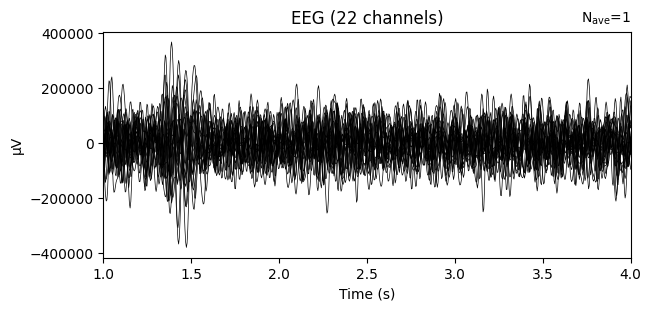

In [11]:
# 获取数据和label及ICA处理
data = epochs.get_data()
labels = epochs.events[:,-1]

ica = UnsupervisedSpatialFilter(FastICA(22), average=False)
icadata = ica.fit_transform(data)
ev1 = mne.EvokedArray(np.mean(icadata, axis=0), mne.create_info(22, epochs.info['sfreq'],
                        ch_types='eeg'), tmin=tmin)
ev1.plot(show=False, window_title='ICA', time_unit='s')
plt.show()